In [1]:
# --- Célula 1: Importações ---
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import joblib

# --- ADICIONADO: Import do BalancedRandomForestClassifier ---
from imblearn.ensemble import BalancedRandomForestClassifier
# -----------------------------------------------------------

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Métricas de Avaliação
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# --- Célula 2: Carregamento dos Dados Mestres ---

# Carrega a tabela de modelagem mais completa
path_final_table = '../data/processed/modeling_table_final.parquet'  
df_completo = pd.read_parquet(path_final_table)

print(f"Tabela de modelagem mestra carregada com {df_completo.shape[0]} dias e {df_completo.shape[1]} colunas.")
print(f"Período total dos dados: de {df_completo.index.min().date()} a {df_completo.index.max().date()}.")

Tabela de modelagem mestra carregada com 5693 dias e 29 colunas.
Período total dos dados: de 2010-02-10 a 2025-09-11.


In [3]:
# --- DEFINIÇÃO COMPLETA DOS GRUPOS DE FEATURES ---

features_carga = [
    'programada', 
    'verificada', 
    'diferenca_verif_prog'
]
features_geracao = [
    'geracao_total_diaria_go', 
    'geracao_fotovoltaica_diaria', 
    'geracao_hidroelétrica_diaria', 
    'geracao_térmica_diaria'
]
features_rede = [
    'total_mwh_restrito_go', 
    'saldo_intercambio_seco', 
    'restricao_razao_rel', 
    'restricao_razao_cnf', 
    'restricao_razao_ene', 
    'restricao_razao_par', 
    'restricao_origem_loc', 
    'restricao_origem_sis'
]
features_hidrica = [
    'ear_percentual_seco', 
    'ena_percentual_mlt_seco'
]
features_adicionais = [
    'cmo_semanal_seco', 
    'disponibilidade_total_diaria_go', 
    'indicador_ccal_mensal'
]
features_clima = [
    'ghi', 
    'temp2m_c', 
    'precipitacao_mm'
]
features_avancadas = [
    'carga_media_7d', 
    'carga_std_7d', 
    'geracao_media_7d', 
    'ear_ontem', 
    'ear_diff_3d', 
    'margem_oferta_demanda', 
    'pressao_demanda_ear', 
    'precip_acumulada_14d', 
    'precip_acumulada_30d'
]
features_calendario = [
    'mes' , 
    'dia_da_semana', 
    'dia_do_ano'
]

print("Grupos de features definidos com sucesso.")

Grupos de features definidos com sucesso.


In [4]:
# --- Célula 4: Painel de Controle do Experimento (BalancedRandomForest) ---
import sys
sys.path.append('..')
from config import END_YEAR

# --- ESCOLHA O CENÁRIO PARA TESTAR ---
# Opções: 'pos_2022', 'pos_2020', 'pos_2017', 'pos_2015', 'pos_2013', 'pos_2010'
CENARIO_ESCOLHIDO = 'pos_2010' 
# -------------------------------------

# Define o período de análise e as features com base no cenário escolhido
if CENARIO_ESCOLHIDO == 'pos_2022':
    START_YEAR = 2022
    nome_cenario = "BalancedRF Pós-2022 (Features de Geração)"
    features_para_teste_nomes = (
        features_geracao + 
        features_rede + 
        features_hidrica +
        features_adicionais + 
        features_clima + 
        features_calendario +
        features_avancadas + 
        ['programada'] 
    )
elif CENARIO_ESCOLHIDO == 'pos_2020':
    START_YEAR = 2020
    nome_cenario = "BalancedRF Pós-2020 (Histórico com Carga Prog.)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas + 
        ['programada']
    )
elif CENARIO_ESCOLHIDO == 'pos_2017':
    START_YEAR = 2017
    nome_cenario = "BalancedRF Pós-2017 (Histórico Intermediário)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2015':
    START_YEAR = 2015
    nome_cenario = "BalancedRF Pós-2015 (Histórico com Disponibilidade)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2013':
    START_YEAR = 2013
    nome_cenario = "BalancedRF Pós-2013 (Histórico Extendido Básico)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_clima + 
        features_calendario + 
        features_avancadas + 
        ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
elif CENARIO_ESCOLHIDO == 'pos_2010':
    START_YEAR = 2010
    nome_cenario = "BalancedRF Pós-2010 (Máximo Histórico Básico)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_clima + 
        features_calendario + 
        features_avancadas + 
        ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
else:
    raise ValueError("Cenário escolhido é inválido.")

print(f"--- INICIANDO EXPERIMENTO COM O CENÁRIO: '{nome_cenario}' ---")
print(f"Período de análise: de {START_YEAR} a {END_YEAR}")

# Filtra e seleciona os dados
anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()
features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

print(f"Número de features selecionadas: {len(X.columns)}")
print("\nAmostragem de classes no dataset:")
print(y.value_counts())

--- INICIANDO EXPERIMENTO COM O CENÁRIO: 'BalancedRF Pós-2010 (Máximo Histórico Básico)' ---
Período de análise: de 2010 a 2025
Número de features selecionadas: 15

Amostragem de classes no dataset:
nivel_risco
baixo    5328
alto      183
medio     182
Name: count, dtype: int64


In [5]:
# --- Célula 5: Preparação dos Dados (SEM SMOTE) ---

mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Aplica o escalonamento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Distribuição das classes nos dados de TREINO (antes do balanceamento do modelo):")
print(y_train.value_counts())
print("\nPreparação dos dados concluída (sem oversampling).")

Distribuição das classes nos dados de TREINO (antes do balanceamento do modelo):
nivel_risco
0    3730
2     128
1     127
Name: count, dtype: int64

Preparação dos dados concluída (sem oversampling).


In [6]:
# --- Célula 6: Busca de Hiperparâmetros com BalancedRandomForestClassifier ---

# Grade de parâmetros para o BalancedRandomForest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None], # None = sem limite
    'max_features': ['sqrt', 'log2'], # Número de features a considerar em cada split
    'min_samples_leaf': [1, 2, 4], # Mínimo de amostras por folha
    'criterion': ['gini', 'entropy']
}

# Instancia o classificador
# O 'sampling_strategy' e 'replacement' são os parâmetros chave do balanceamento
brf = BalancedRandomForestClassifier(
    sampling_strategy='all', # Reamostra todas as classes
    replacement=True,        # Permite que amostras sejam escolhidas mais de uma vez
    random_state=42
)

# Configura a busca aleatória
random_search = RandomizedSearchCV(
    estimator=brf, 
    param_distributions=param_grid, 
    n_iter=20,
    cv=4,
    scoring='recall_weighted', 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
)

print("\nIniciando a busca de hiperparâmetros para o BalancedRandomForestClassifier...")
# O treino é feito nos dados escalonados, mas NÃO reamostrados
random_search.fit(X_train_scaled, y_train)
print("Busca de hiperparâmetros concluída.")

best_model_brf = random_search.best_estimator_
print("\nMelhores parâmetros encontrados:", random_search.best_params_)


Iniciando a busca de hiperparâmetros para o BalancedRandomForestClassifier...
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Busca de hiperparâmetros concluída.

Melhores parâmetros encontrados: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}



--- Resultados Finais do Cenário: BalancedRF Pós-2010 (Máximo Histórico Básico) ---
              precision    recall  f1-score   support

       baixo       0.95      0.70      0.81      1598
       medio       0.04      0.16      0.06        55
        alto       0.04      0.22      0.07        55

    accuracy                           0.67      1708
   macro avg       0.34      0.36      0.31      1708
weighted avg       0.89      0.67      0.76      1708



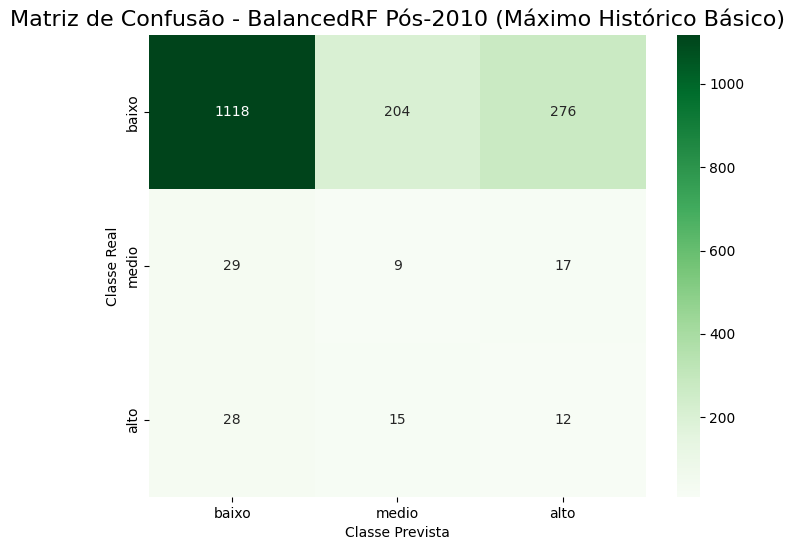

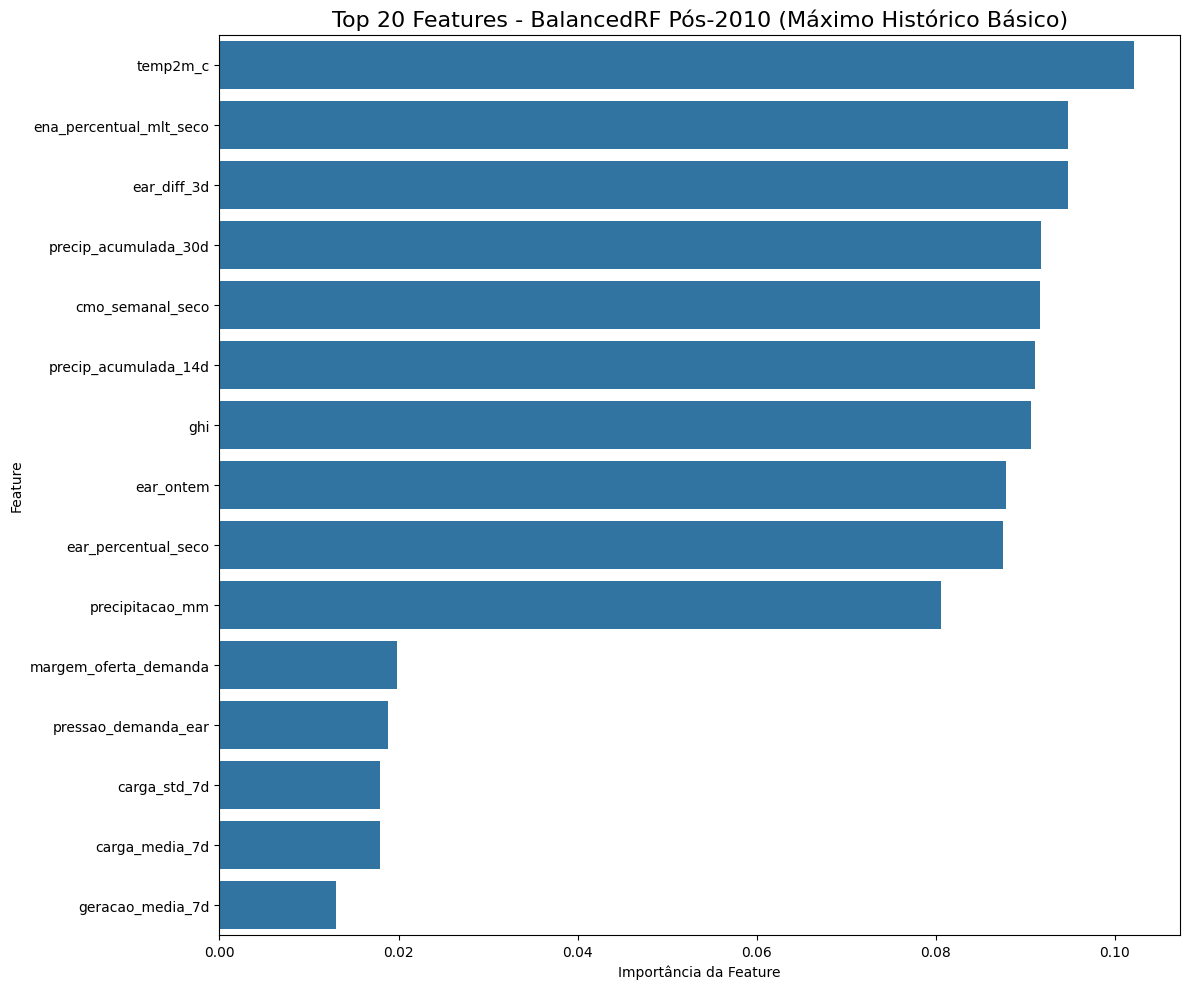


Modelo BalancedRandomForest salvo com sucesso em: ../models/best_brf_model_2010.joblib
Scaler salvo com sucesso em: ../models/scaler_brf_2010.joblib


In [7]:
# --- Célula 7: Avaliação Final e Salvamento do Modelo ---

# Avaliação no conjunto de teste
y_pred = best_model_brf.predict(X_test_scaled)
print(f"\n--- Resultados Finais do Cenário: {nome_cenario} ---")
print(classification_report(y_test, y_pred, target_names=mapeamento_risco.keys(), zero_division=0))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title(f'Matriz de Confusão - {nome_cenario}', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# Análise de Importância das Features
feature_names = X.columns
importances = best_model_brf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title(f'Top 20 Features - {nome_cenario}', fontsize=16)
plt.xlabel('Importância da Feature')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- CORREÇÃO ABAIXO ---

# --- Salvar o modelo treinado com nome dinâmico ---
# Extrai o ano do cenário para criar nomes de arquivo dinâmicos (ex: 'pos_2020' -> '2020')
year_str = CENARIO_ESCOLHIDO.split('_')[1]

# Define os caminhos dos arquivos de forma dinâmica
output_path = f'../models/best_brf_model_{year_str}.joblib'
scaler_path = f'../models/scaler_brf_{year_str}.joblib'

# Cria o diretório se ele não existir
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Salva o modelo e o scaler
joblib.dump(best_model_brf, output_path)
joblib.dump(scaler, scaler_path)

# Imprime as mensagens com os nomes dinâmicos
print(f"\nModelo BalancedRandomForest salvo com sucesso em: {output_path}")
print(f"Scaler salvo com sucesso em: {scaler_path}")